##Group Members: Travis Counihan, David Nguyen, Richard Perez

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CP483_Project')

Mounted at /content/drive


In [ ]:
# Imports for data manipulation, processing, and visuals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import joblib
import pickle


In [ ]:
# Read the processed data file
data = pd.read_csv('BitcoinHeistDataPREPROCESSED.csv')
data_length = len(data)

In [ ]:
# Print columns to see order of proccessed data labels
print(data.columns)

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'log_income', 'label'],
      dtype='object')


In [ ]:
# Save the feature and label labels for ease of use when graphing
feature_labels = ['length', 'weight', 'count', 'looped', 'neighbors', 'income',
                  'log_income']
target_label = ['label']

- Feature Definitions
  - address > Unique Bitcoin wallet address (string ID).
  - year >
Year of the transaction day (e.g., 2016, 2017).
  - day >
Day of the year (1 = Jan 1, 365 = Dec 31).
  - length > Number of mixing rounds — how many times coins are split and recombined to obscure origin (higher = more obfuscation).
  - weight > Fraction of transaction outputs that come from merged inputs — measures coin merging behavior (0 to 1+).
  - count > Total number of transactions involving the address in the 24-hour window.
  - looped > Number of looped transactions — coins sent out and returned via complex paths (used for laundering).
  - neighbors > Number of distinct addresses this address transacted with in the day.
  - income > Total Bitcoin received in satoshis (1 BTC = 100M satoshis).
  - label > Ransomware family (e.g., princetonCerber, montrealCryptXXX) or white (non-ransomware).




- Also, there is no missing data as mentioned on the source page https://archive.ics.uci.edu/dataset/526/bitcoinheistransomwareaddressdataset"

In [ ]:
#-------------------------------------------------------------------------------
# Define size of trainng data and test data (we chose an 80 20 split)
#-------------------------------------------------------------------------------

# training_size = round(0.8*data_length)
# test_size = data_length - training_size

#-------------------------------------------------------------------------------
# Comment out because replaced with train_test_split since it randomizes and
# keeps class balance
#-------------------------------------------------------------------------------


In [ ]:
#-------------------------------------------------------------------------------
# Make the training and test data variables
#-------------------------------------------------------------------------------

# train_data = data.loc[0:training_size+1,feature_labels]
# test_data = data.loc[training_size+2:,feature_labels]

#-------------------------------------------------------------------------------
# Comment out because replaced with train_test_split since it randomizes and
# keeps class balance
#-------------------------------------------------------------------------------

In [ ]:
#-------------------------------------------------------------------------------
# Feature Engineering (Required for properly functioning models)
#-------------------------------------------------------------------------------

# Make an engineered data frame to add engineered data to
engineered_data = data.copy()

# Log scale eighbors to reduce skewness
engineered_data['log_count'] = np.log1p(data['count'])

# Log scale eighbors to reduce skewness
engineered_data['log_weight'] = np.log1p(data['weight'])

# Log scale eighbors to reduce skewness
engineered_data['log_income'] = np.log1p(data['income'])

# Normalizes income by transaction volume
engineered_data['income_per_trx'] = data['income'] / data['count']

# Merging intensity per transaction
engineered_data['merge_ratio']= data['weight'] / data['count']

# Fraction of looped transactions
engineered_data['looped_ratio'] = data['looped'] / data['count']

# Binary flag for any looping
engineered_data['is_looped'] = (data['looped'] > 0).astype(int)

# Flag large payments (common in ransomware)
engineered_data['high_income'] = (data['income'] > 1e8).astype(int)

# Log scale neighbors to reduce skewness
engineered_data['log_neighbors'] = np.log1p(data['neighbors'])

# Encoded data to be used with model
le = skl.preprocessing.LabelEncoder()
engineered_data['encoded_label'] = le.fit_transform(data['label'])

# Filter out classes with fewer than 2 samples to enable stratification
class_counts = engineered_data['encoded_label'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
engineered_data = engineered_data[engineered_data['encoded_label'].isin(valid_classes)]

# Save encoder for later
joblib.dump(le, 'label_encoder.pkl')

# Reposition 'label' to the end for engineered_data
engineered_data = engineered_data.drop('label', axis=1)
engineered_data['label'] = data['label']

# ordered_cols = [prefered, order, of, column, names]
# engineered_data.reindex(ordered_cols)

# Use these features for the full feature model
engineered_features = ['log_income', 'log_count', 'log_weight', 'income_per_trx',
                       'merge_ratio', 'looped_ratio', 'is_looped',
                       'high_income','log_neighbors']

# Use these features for reduced feature model
reduced_engineered_features = ['log_income', 'log_count', 'log_weight',
                               'income_per_trx']

# Create binary label: 1 = ransomware (encoded_label == 25), 0 = not ransomware
engineered_data['binary_label'] = (engineered_data['encoded_label'] == 25).astype(int)

print(engineered_data.columns)

# Set the label column for binary classification
engineered_label = 'binary_label'


#-------------------------------------------------------------------------------
# You previously had engineered_label = ['encoded_label'], removed [] since
# engineered_label is a string that is a single column reference I used train_test_split
#-------------------------------------------------------------------------------


Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'log_income', 'log_count', 'log_weight',
       'income_per_trx', 'merge_ratio', 'looped_ratio', 'is_looped',
       'high_income', 'log_neighbors', 'encoded_label', 'label',
       'binary_label'],
      dtype='object')


In [ ]:
#-------------------------------------------------------------------------------
# Make the Train-Test split for the full and reduced features
#  (We chose an 80/20 split)
#-------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split

# Use train_test_split so that data is randomized and so that the target is stratified
engineered_train_features, engineered_test_features, engineered_train_target, engineered_test_target = train_test_split(
    engineered_data[engineered_features],engineered_data[engineered_label],
    test_size=0.2, random_state=42, stratify= engineered_data[engineered_label])

reduced_engineered_train_features, reduced_engineered_test_features, reduced_engineered_train_target, reduced_engineered_test_target = train_test_split(
    engineered_data[reduced_engineered_features],
    engineered_data[engineered_label], test_size=0.2, random_state=42,
    stratify=engineered_data[engineered_label])

#-------------------------------------------------------------------------------
# I replaced the commented out section with train_test_split so that we do not
# have to manually split our data and so that the class balance of the target
# label is maintained
#-------------------------------------------------------------------------------

# # Full features
# engineered_train_features = engineered_data.loc[0:training_size+1,
#                                                 engineered_features]
# engineered_train_target = engineered_data.loc[0:training_size+1,
#                                               engineered_label]

# engineered_test_data = engineered_data.loc[training_size+2:,engineered_features]

# # Reduced features
# reduced_engineered_train_features = engineered_data.loc[0:training_size+1,
#                                                     reduced_engineered_features]
# reduced_engineered_train_target = engineered_data.loc[0:training_size+1,
#                                                        engineered_label]

# reduced_engineered_test_data = engineered_data.loc[training_size+2:,
#                                                    reduced_engineered_features]

# # Test feature (Works for both full and reduced)
# engineered_test_target = engineered_data.loc[training_size+2:,
#                                              reduced_engineered_features]


- Engineered Feature Definitions
  - log_income > log-transform of raw income to reduce right skew.
  - log_count > log-transform of transaction count.
  - log_weight > log-transform of merge intensity.
  - income_per_trx > average income per transaction.
  - merge_ratio > average merge intensity per transaction.
  - looped_ratio > fraction of transactions that are looped.
  - is_looped > Binary: 1 if looped > 0, else 0 — any looping activity?
  - high_income > Binary: 1 if income > 100M satoshis (~1 BTC), else 0 — large payments common in ransom.
  - log_neighbors > reduces skew in neighbor count.
  - encoded_label > integer encoded label for model handeling

In [ ]:
#-------------------------------------------------------------------------------
# KNN Elbow Plot for Full Features (Find best K value)
#-------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score

# Going to test K values from 1 to 50
k_values = range(1, 51, 2)

# Going to plot Error vs. K value
err_list = []

# Loop through all K values
for k in k_values:
  full_knn_elbow = skl.neighbors.KNeighborsClassifier(n_neighbors=k)
  full_knn_elbow.fit(engineered_train_features, engineered_train_target)
  knn_prediction = full_knn_elbow.predict(engineered_test_features)
  error = 1 - accuracy_score(engineered_test_target, knn_prediction)
  err_list.append(error)

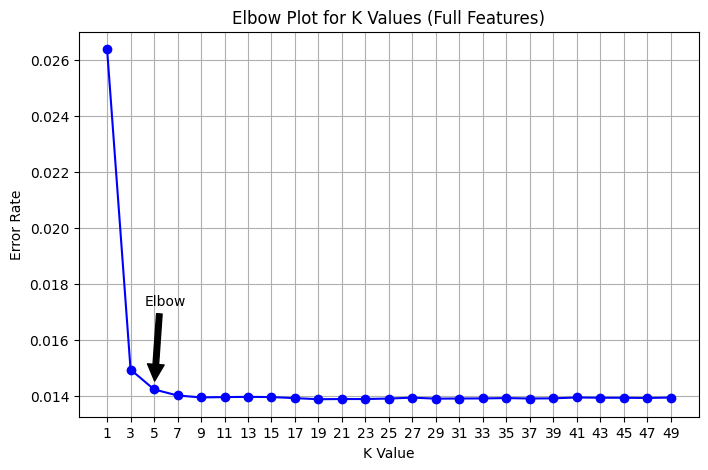

In [ ]:

# Plot the Full Features Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, err_list, marker='o', linestyle='-', color='b')
plt.title('Elbow Plot for K Values (Full Features)')
plt.annotate("", xy=(5, err_list[2]), xytext=(5.5, err_list[2] + 0.003),
    arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.text(6, err_list[2] + 0.003, "Elbow", horizontalalignment="center")
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
#-------------------------------------------------------------------------------
# KNN - Full Features
#-------------------------------------------------------------------------------

# Full feature model implementation
# From elbow plot, 5 seems to be lowest error rate
full_KNN = skl.neighbors.KNeighborsClassifier(n_neighbors=5)

# Full feature model fit to training data (Had to flatten feature to 1D array to
# suppress warning)
full_KNN.fit(engineered_train_features, engineered_train_target.values.ravel())

KNeighborsClassifier()

In [ ]:
#-------------------------------------------------------------------------------
# KNN Elbow Plot for Reduced Features (Find best K value)
#-------------------------------------------------------------------------------
from sklearn.metrics import accuracy_score

# Going to test K values from 1 to 50
k_values = range(1, 51, 2)

# Going to plot Error vs. K value
err_list = []

# Loop through all K values
for k in k_values:
  reduced_knn_elbow = skl.neighbors.KNeighborsClassifier(n_neighbors=k)
  reduced_knn_elbow.fit(reduced_engineered_train_features, reduced_engineered_train_target)
  knn_prediction = reduced_knn_elbow.predict(reduced_engineered_test_features)
  error = 1 - accuracy_score(reduced_engineered_test_target, knn_prediction)
  err_list.append(error)



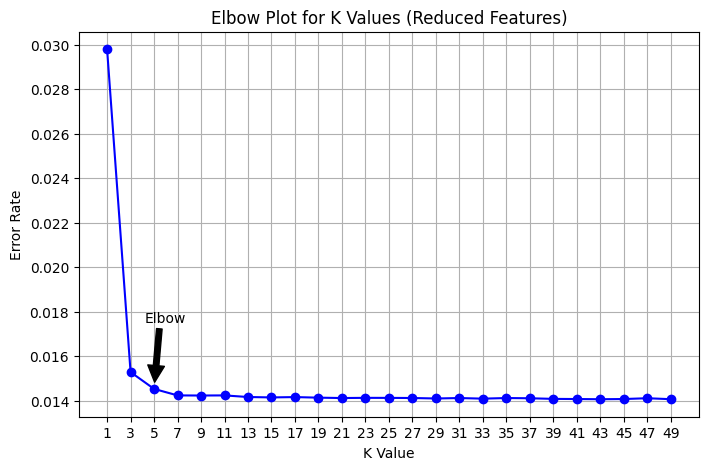

In [ ]:

# Plot the Reduced Features Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, err_list, marker='o', linestyle='-', color='b')
plt.title('Elbow Plot for K Values (Reduced Features)')
plt.annotate("", xy=(5, err_list[2]), xytext=(5.5, err_list[2] + 0.003),
    arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.text(6, err_list[2] + 0.003, "Elbow", horizontalalignment="center")
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
#-------------------------------------------------------------------------------
# KNN - Reduced Features
#-------------------------------------------------------------------------------

# Reduced feature model implementation
# From elbow plot, 5 seems to be lowest error rate
reduced_KNN = skl.neighbors.KNeighborsClassifier(n_neighbors=5)

# Reduced feature model fit to training data (Had to flatten feature to 1D array to
# suppress warning)
reduced_KNN.fit(reduced_engineered_train_features, reduced_engineered_train_target.values.ravel())

KNeighborsClassifier()

In [ ]:
#-------------------------------------------------------------------------------
# Saving full features model to disk for submission
#-------------------------------------------------------------------------------

# save the model to disk
filename = 'Full_KNN.sav'
pickle.dump(full_KNN, open(filename, 'wb'))

In [ ]:
#-------------------------------------------------------------------------------
# Saving reduced features model to disk for submission
#-------------------------------------------------------------------------------

# save the model to disk
filename = 'Reduced_KNN.sav'
pickle.dump(reduced_KNN, open(filename, 'wb'))

##--3 More ML Models--

In [ ]:
#-------------------------------------------------------------------------------
# Random Forest - Full Features
# NOTE: Need to use class weights because 'white' is ~99% of data
#-------------------------------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier

# Full feature model implementation
full_randomf = RandomForestClassifier(
    n_estimators=100,               # Set number of trees to 100
    max_depth=None,                 # No depth limit set
    min_samples_split=2,            # Default value of 2 samples needed to split
    min_samples_leaf=1,             # Default value of 1 sample per leaf set
    class_weight='balanced',        # Set so class imbalanced resolved
    random_state=42,                # Set to reproduce the randomness
    n_jobs=-1                       # Use all available CPU cores for training
)

# Full feature model fit to training data
full_randomf.fit(engineered_train_features, engineered_train_target.values.ravel())

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
#-------------------------------------------------------------------------------
# Random Forest - Reduced Features
# NOTE: Need to use class weights because 'white' is ~99% of data
#-------------------------------------------------------------------------------

# Reduced feature model implementation
reduced_randomf = RandomForestClassifier(
    n_estimators=100,               # Set number of trees to 100
    max_depth=None,                 # No depth limit set
    min_samples_split=2,            # Default value of 2 samples needed to split
    min_samples_leaf=1,             # Default value of 1 sample per leaf set
    class_weight='balanced',        # Set so class imbalanced resolved
    random_state=42,                # Set to reproduce the randomness
    n_jobs=-1                       # Use all available CPU cores for training
)

# Reduced feature model fit to training data
reduced_randomf.fit(reduced_engineered_train_features, reduced_engineered_train_target.values.ravel())

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
#-------------------------------------------------------------------------------
# Saving full/reduced features Random Forest model for submission
#-------------------------------------------------------------------------------

# save the model to disk
filename = 'Full_RF.sav'
pickle.dump(full_randomf, open(filename, 'wb'))

filename = 'Reduced_RF.sav'
pickle.dump(reduced_randomf, open(filename, 'wb'))

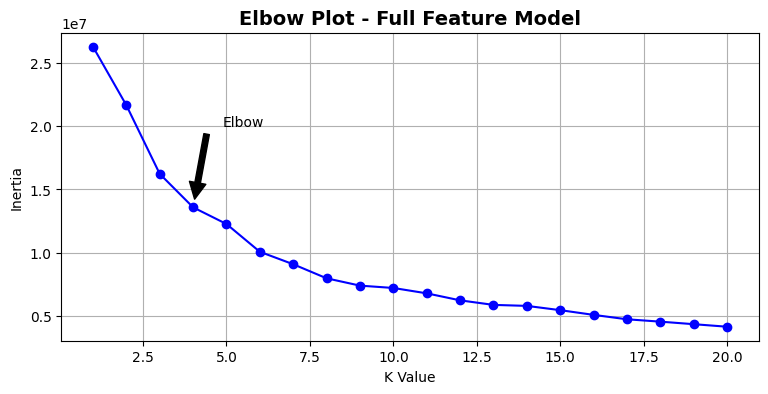

In [ ]:
#-------------------------------------------------------------------------------
# K-Means Clustering Elbow Plot (Full Feature Model)
#-------------------------------------------------------------------------------

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Copy only the input features and not target variable since unsupervised learning
kmeans_data = engineered_data[engineered_features].copy()

# From 09_unsupervised_learning.ipynb, generate elbow plot for Inertia vs K Plot
# Test K values from 1 to 20
kmeans_kval = [
    Pipeline([
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=k, n_init="auto", random_state=42))
    ]).fit(kmeans_data)
    for k in range(1, 21)
]
inertias = [model.named_steps["kmeans"].inertia_ for model in kmeans_kval]
plt.figure(figsize=(9, 4))
plt.plot(range(1, 21), inertias, "bo-")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 20000000),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(5.5, 20000000, "Elbow", horizontalalignment="center")
plt.title("Elbow Plot - Full Feature Model", fontsize=14, fontweight="bold")
plt.grid()
plt.show()

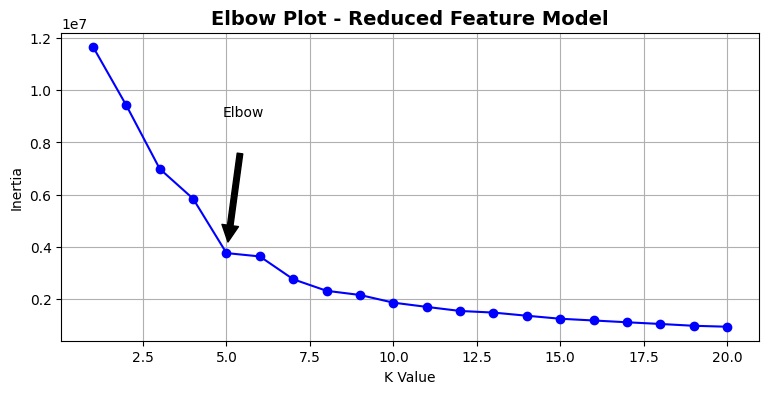

In [ ]:
#-------------------------------------------------------------------------------
# K-Means Clustering Elbow Plot (Reduced Feature Model)
#-------------------------------------------------------------------------------

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Copy only the input features and not target variable since unsupervised learning
reduced_kmeans_data = engineered_data[reduced_engineered_features].copy()

# From 09_unsupervised_learning.ipynb, generate elbow plot for Inertia vs K Plot
# Test K values from 1 to 20
reduced_kmeans_kval = [
    Pipeline([
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=k, n_init="auto", random_state=42))
    ]).fit(reduced_kmeans_data)
    for k in range(1, 21)
]
inertias = [model.named_steps["kmeans"].inertia_ for model in reduced_kmeans_kval]
plt.figure(figsize=(9, 4))
plt.plot(range(1, 21), inertias, "bo-")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.annotate("", xy=(5, inertias[4]), xytext=(5.45, 8000000),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(5.5, 9000000, "Elbow", horizontalalignment="center")
plt.title("Elbow Plot - Reduced Feature Model", fontsize=14, fontweight="bold")
plt.grid()
plt.show()

In [ ]:
# From elbow plot, k value of 4 has deepest drop, choose 4 as number of clusters
# Full feature model implementation

full_kmeans = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, n_init="auto", random_state=42))
])

# Full feature model fit to training data
full_kmeans.fit(kmeans_data)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [ ]:
# From elbow plot, k value of 5 has deepest drop, choose 5 as number of clusters
# Reduced feature model implementation

reduced_kmeans_data = engineered_data[reduced_engineered_features].copy()

reduced_kmeans = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=5, n_init="auto", random_state=42))
])

# Reduced feature model fit to training data
reduced_kmeans.fit(reduced_kmeans_data)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=5, random_state=42))])

In [ ]:
#-------------------------------------------------------------------------------
# Saving full features K Means Clustering and reduced features model for submission
#-------------------------------------------------------------------------------

# save the model to disk
filename = 'Full_KMeans.sav'
pickle.dump(full_kmeans, open(filename, 'wb'))

filename = 'Reduced_KMeans.sav'
pickle.dump(reduced_kmeans, open(filename, 'wb'))

In [ ]:
#-------------------------------------------------------------------------------
# Support Vector Machine (SVM) - Full Features
# NOTE: Need to use class weights because 'white' is ~99% of data
#-------------------------------------------------------------------------------

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Initialize the SVM model

# Use Pipeline to chain steps together like the examples in the class notebook 05_support_vector_machines.ipynb
# Feature scaling, mean for all features is now 0, standard deviation is 1
# Set kernel to Radial Basis Function since data is nonlinear
# C (Regularization Parameter) set to default value of 1, gamma set to default value of scale
# Class weight set to balanced, so that more weight is given to our ransomware data
full_SVM = Pipeline([
    ("scaler", StandardScaler()),             # Standardizes all the features in the data so that they are on the same scale
    ("svm", LinearSVC(C=1, class_weight='balanced', random_state=42, max_iter=10000))
])
# Full feature model fit to training data
full_SVM.fit(engineered_train_features, engineered_train_target.values.ravel())


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 LinearSVC(C=1, class_weight='balanced', max_iter=10000,
                           random_state=42))])

In [ ]:
#-------------------------------------------------------------------------------
# Support Vector Machine (SVM) - Reduced Features
# NOTE: Need to use class weights because 'white' is ~99% of data
#-------------------------------------------------------------------------------

# Reduced feature model implementation
reduced_SVM = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=1, class_weight='balanced', random_state=42, max_iter=10000))
])
# Reduced feature model fit to training data
reduced_SVM.fit(reduced_engineered_train_features, reduced_engineered_train_target.values.ravel())


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 LinearSVC(C=1, class_weight='balanced', max_iter=10000,
                           random_state=42))])

In [ ]:
#-------------------------------------------------------------------------------
# Saving full features SVM and reduced features SVM model to disk for submission
#-------------------------------------------------------------------------------

# save the model to disk
filename = 'Full_SVM.sav'
pickle.dump(full_SVM, open(filename, 'wb'))

filename = 'Reduced_SVM.sav'
pickle.dump(reduced_SVM, open(filename, 'wb'))